In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import csv

Import and Analysis of the dataset

In [2]:
df = pd.read_csv('tweet_emotions.csv')
print(df.head())

     tweet_id   sentiment                                            content
0  1956967341       empty  @tiffanylue i know  i was listenin to bad habi...
1  1956967666     sadness  Layin n bed with a headache  ughhhh...waitin o...
2  1956967696     sadness                Funeral ceremony...gloomy friday...
3  1956967789  enthusiasm               wants to hang out with friends SOON!
4  1956968416     neutral  @dannycastillo We want to trade with someone w...


In [3]:
print(df.shape)

(40000, 3)


In [4]:
unique_emotions = df['sentiment'].unique()
print(unique_emotions)

['empty' 'sadness' 'enthusiasm' 'neutral' 'worry' 'surprise' 'love' 'fun'
 'hate' 'happiness' 'boredom' 'relief' 'anger']


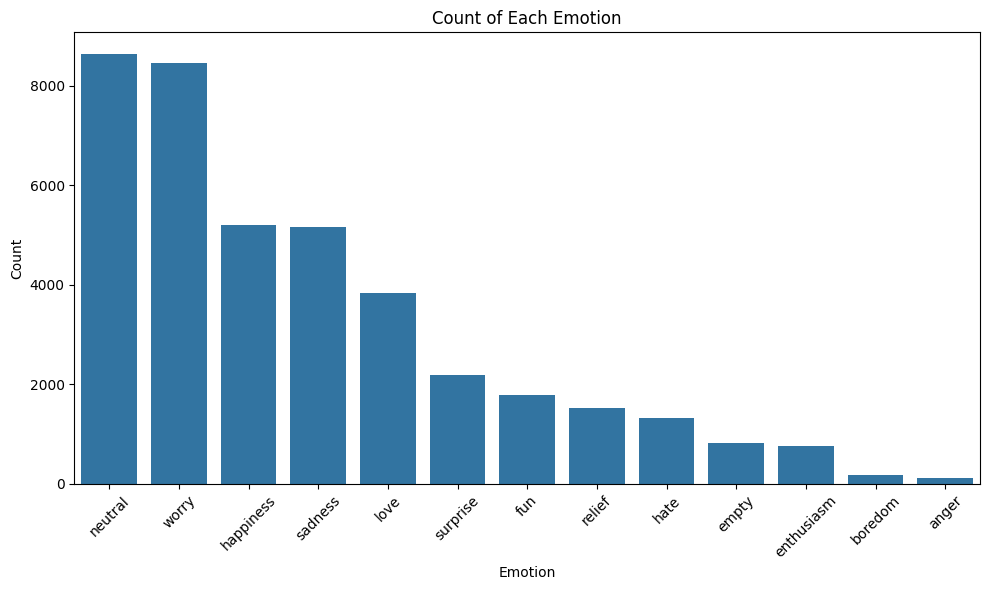

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='sentiment', order=df['sentiment'].value_counts().index)
plt.title('Count of Each Emotion')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
print(df['sentiment'].isnull().sum())
print(df['content'].isnull().sum())

0
0


In [7]:
df.drop(columns=['tweet_id'], axis = 1, inplace=True)
print(df.head())

    sentiment                                            content
0       empty  @tiffanylue i know  i was listenin to bad habi...
1     sadness  Layin n bed with a headache  ughhhh...waitin o...
2     sadness                Funeral ceremony...gloomy friday...
3  enthusiasm               wants to hang out with friends SOON!
4     neutral  @dannycastillo We want to trade with someone w...


In [8]:
emotions_dict = {item:i for i , item in enumerate(df.sentiment.value_counts().index)}
print(emotions_dict)

{'neutral': 0, 'worry': 1, 'happiness': 2, 'sadness': 3, 'love': 4, 'surprise': 5, 'fun': 6, 'relief': 7, 'hate': 8, 'empty': 9, 'enthusiasm': 10, 'boredom': 11, 'anger': 12}


In [9]:
df['emotion_label'] = df.sentiment.map(emotions_dict)
print(df.head())

    sentiment                                            content  \
0       empty  @tiffanylue i know  i was listenin to bad habi...   
1     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2     sadness                Funeral ceremony...gloomy friday...   
3  enthusiasm               wants to hang out with friends SOON!   
4     neutral  @dannycastillo We want to trade with someone w...   

   emotion_label  
0              9  
1              3  
2              3  
3             10  
4              0  


In [10]:
import re
def clean_text(text):
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return cleaned_text
df['cleaned_text'] = df['content'].apply(clean_text)
print(df.head())

    sentiment                                            content  \
0       empty  @tiffanylue i know  i was listenin to bad habi...   
1     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2     sadness                Funeral ceremony...gloomy friday...   
3  enthusiasm               wants to hang out with friends SOON!   
4     neutral  @dannycastillo We want to trade with someone w...   

   emotion_label                                       cleaned_text  
0              9  tiffanylue i know  i was listenin to bad habit...  
1              3  Layin n bed with a headache  ughhhhwaitin on y...  
2              3                      Funeral ceremonygloomy friday  
3             10                wants to hang out with friends SOON  
4              0  dannycastillo We want to trade with someone wh...  


In [11]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

df['tokenized_text'] = df['cleaned_text'].apply(word_tokenize)
print(df.head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


    sentiment                                            content  \
0       empty  @tiffanylue i know  i was listenin to bad habi...   
1     sadness  Layin n bed with a headache  ughhhh...waitin o...   
2     sadness                Funeral ceremony...gloomy friday...   
3  enthusiasm               wants to hang out with friends SOON!   
4     neutral  @dannycastillo We want to trade with someone w...   

   emotion_label                                       cleaned_text  \
0              9  tiffanylue i know  i was listenin to bad habit...   
1              3  Layin n bed with a headache  ughhhhwaitin on y...   
2              3                      Funeral ceremonygloomy friday   
3             10                wants to hang out with friends SOON   
4              0  dannycastillo We want to trade with someone wh...   

                                      tokenized_text  
0  [tiffanylue, i, know, i, was, listenin, to, ba...  
1  [Layin, n, bed, with, a, headache, ughhhhwaiti...  

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df['cleaned_text'] = df['tokenized_text'].apply(lambda x: ' '.join(x))
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['emotion_label'], test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("Shape of X_train_tfidf:", X_train_tfidf.shape)
print("Shape of X_test_tfidf:", X_test_tfidf.shape)

Shape of X_train_tfidf: (32000, 45596)
Shape of X_test_tfidf: (8000, 45596)


In [13]:
from scipy.sparse import csr_matrix

# Fit and transform the training data
X_train_tfidf = csr_matrix(tfidf_vectorizer.fit_transform(X_train))

# Transform the test data
X_test_tfidf = csr_matrix(tfidf_vectorizer.transform(X_test))

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

In [15]:
from tensorflow.keras.layers import TextVectorization
MAX_WORDS = 10000
MAX_LEN = 100

vectorizer_layer = TextVectorization(max_tokens=MAX_WORDS, output_mode='int', output_sequence_length=MAX_LEN)
vectorizer_layer.adapt(X_train)

In [16]:
MAX_FEATURES = 10000
EMBEDDING_DIM = 100
N_CLASSES = len(np.unique(y_train))

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the model
model = models.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string),
    layers.Embedding(MAX_FEATURES, EMBEDDING_DIM),
    layers.SpatialDropout1D(0.2),
    layers.GlobalMaxPooling1D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='gelu'),
    layers.Dropout(0.4),
    layers.Dense(N_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_encoded)
print("Test Accuracy:", accuracy)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 100)            1000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 1, 100)            0         
 Dropout1D)                                                      
                                                                 
 global_max_pooling1d (Glob  (None, 100)               0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 256)               25856     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

UnimplementedError: Graph execution error:

Detected at node sequential/embedding/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-04d04d671504>", line 26, in <cell line: 26>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py", line 223, in call

Cast string to int32 is not supported
	 [[{{node sequential/embedding/Cast}}]] [Op:__inference_train_function_3267]

In [ ]:
from tensorflow.keras.models import save_model
import joblib


save_model(model, 'emotion_model.h5')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')
joblib.dump(X_train_tfidf, 'X_train_tfidf.joblib')
joblib.dump(X_test_tfidf, 'X_test_tfidf.joblib')

In [ ]:
vocabulary_size = len(tfidf_vectorizer.vocabulary_)
print(vocabulary_size)

In [ ]:
def preprocess_text(text):
    # Load TF-IDF vectorizer
    tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

    # Vectorize the input text
    text_vectorized = tfidf_vectorizer.transform([text]).toarray()

    return text_vectorized

def predict_emotion(text_vectorized):
    # Load trained model
    model = models.load_model('emotion_model.h5')

    # Predict the emotion probabilities
    probabilities = model.predict(text_vectorized)

    # Get the predicted emotion label
    predicted_emotion_index = np.argmax(probabilities)
    predicted_emotion = label_encoder.classes_[predicted_emotion_index]

    # Get the confidence (probability) of the predicted emotion
    confidence = probabilities[0][predicted_emotion_index]

    return predicted_emotion, confidence

# Main loop
while True:
    txt = input("Text : ")
    text_vectorized = preprocess_text(txt)
    emotion, confidence = predict_emotion(text_vectorized)
    print("Predicted Emotion:", emotion)
    print("Confidence:", confidence)